# Anscombe's Quartet — Analysis & Visualisation

Anscombe's Quartet consists of four datasets that have nearly **identical summary statistics** (mean, variance, correlation, regression line) but look very different when plotted.

This notebook:
1. Loads the data and prints descriptive statistics
2. Plot 1 — 2×2 scatter grid with OLS regression lines (canonical)
3. Plot 2 — Side-by-side box plots of `y` per dataset
4. Plot 3 — 2×2 residual plots (residuals vs. fitted values)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# ── Load data ────────────────────────────────────────────────
df = pd.read_csv('anscombe_quartet.tsv', sep='\t')
print(df.head())
print(f'\nShape: {df.shape}')
print(f'Datasets: {sorted(df["dataset"].unique())}')

  dataset   x     y
0       I  10  8.04
1       I   8  6.95
2       I  13  7.58
3       I   9  8.81
4       I  11  8.33

Shape: (44, 3)
Datasets: ['I', 'II', 'III', 'IV']


## Descriptive Statistics

The table below confirms the near-identical summary statistics across all four datasets.

In [2]:
def ols(x, y):
    """Return (intercept, slope) of OLS fit."""
    mx, my = x.mean(), y.mean()
    slope = ((x - mx) * (y - my)).sum() / ((x - mx) ** 2).sum()
    return my - slope * mx, slope

rows = []
for ds, g in df.groupby('dataset', sort=True):
    x, y = g['x'], g['y']
    b0, b1 = ols(x, y)
    r = np.corrcoef(x, y)[0, 1]
    rows.append({
        'Dataset': ds,
        'x mean': round(x.mean(), 4),
        'x stdev': round(x.std(ddof=1), 4),
        'y mean': round(y.mean(), 4),
        'y stdev': round(y.std(ddof=1), 4),
        'Pearson r': round(r, 4),
        'OLS intercept': round(b0, 4),
        'OLS slope': round(b1, 4),
    })

stats = pd.DataFrame(rows).set_index('Dataset')
pd.set_option('display.float_format', '{:.4f}'.format)
print(stats.to_string())

         x mean  x stdev  y mean  y stdev  Pearson r  OLS intercept  OLS slope
Dataset                                                                       
I        9.0000   3.3166  7.5009   2.0316     0.8164         3.0001     0.5001
II       9.0000   3.3166  7.5009   2.0317     0.8162         3.0009     0.5000
III      9.0000   3.3166  7.5000   2.0304     0.8163         3.0025     0.4997
IV       9.0000   3.3166  7.5009   2.0306     0.8165         3.0017     0.4999


## Plot 1 — 2×2 Scatter Grid with OLS Regression Lines

The canonical Anscombe visualisation. The four datasets look completely different despite sharing the same summary statistics.

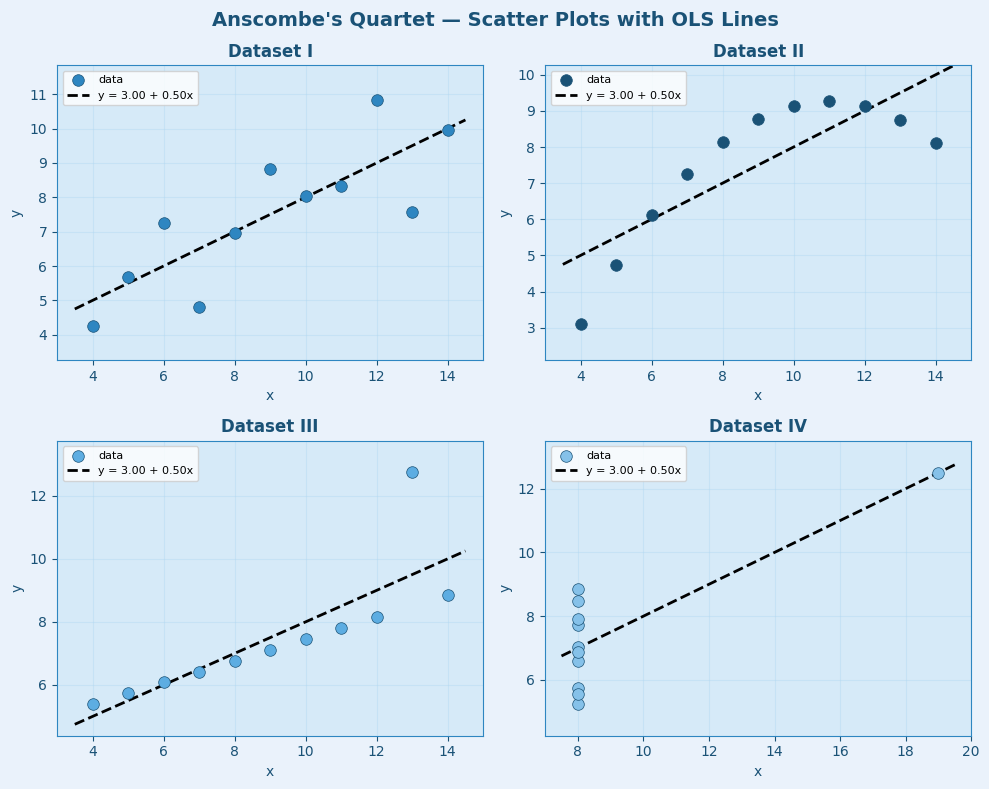

Saved: plot1_scatter.png


In [3]:
datasets = sorted(df['dataset'].unique())
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=False, sharey=False)
fig.patch.set_facecolor('#EAF2FB')
fig.suptitle("Anscombe's Quartet — Scatter Plots with OLS Lines", fontsize=14, fontweight='bold', color='#1A5276')

blue_shades = ['#2E86C1', '#1A5276', '#5DADE2', '#85C1E9']

for ax, ds, dot_color in zip(axes.flat, datasets, blue_shades):
    g = df[df['dataset'] == ds]
    x, y = g['x'].values, g['y'].values
    b0, b1 = ols(g['x'], g['y'])
    x_line = np.linspace(x.min() - 0.5, x.max() + 0.5, 100)

    ax.set_facecolor('#D6EAF8')
    ax.scatter(x, y, color=dot_color, edgecolors='#1A5276', linewidths=0.5, s=70, zorder=3, label='data')
    ax.plot(x_line, b0 + b1 * x_line, color='black', linewidth=2, linestyle='--',
            label=f'y = {b0:.2f} + {b1:.2f}x')
    ax.set_title(f'Dataset {ds}', fontweight='bold', color='#1A5276')
    ax.set_xlabel('x', color='#1A5276')
    ax.set_ylabel('y', color='#1A5276')
    ax.tick_params(colors='#1A5276')
    ax.legend(fontsize=8)
    ax.set_xlim(x.min() - 1, x.max() + 1)
    ax.set_ylim(y.min() - 1, y.max() + 1)
    ax.grid(True, alpha=0.4, color='#AED6F1')
    for spine in ax.spines.values():
        spine.set_edgecolor('#2E86C1')

plt.tight_layout()
plt.savefig('plot1_scatter.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: plot1_scatter.png')

## Plot 2 — Box Plots of `y` per Dataset

Side-by-side box plots showing distributional differences (skew, outliers) that are masked by equal means and standard deviations.

/tmp/ipykernel_37034/3806632812.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(groups, labels=[f'Dataset {ds}' for ds in datasets],


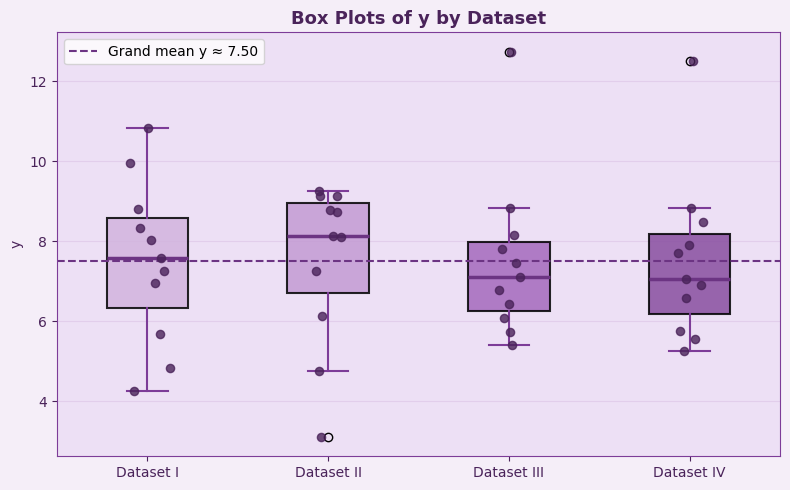

Saved: plot2_boxplots.png


In [4]:
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor('#F5EEF8')
ax.set_facecolor('#EDE0F5')

groups = [df[df['dataset'] == ds]['y'].values for ds in datasets]
bp = ax.boxplot(groups, labels=[f'Dataset {ds}' for ds in datasets],
                patch_artist=True, notch=False,
                medianprops=dict(color='#6C3483', linewidth=2.5),
                whiskerprops=dict(color='#7D3C98', linewidth=1.5),
                capprops=dict(color='#7D3C98', linewidth=1.5),
                boxprops=dict(linewidth=1.5),
                flierprops=dict(marker='o', color='#9B59B6', markersize=6))

purple_shades = ['#D2B4DE', '#C39BD3', '#A569BD', '#884EA0']
for patch, color in zip(bp['boxes'], purple_shades):
    patch.set_facecolor(color)
    patch.set_alpha(0.85)

# Overlay individual points (strip)
for i, g in enumerate(groups, start=1):
    ax.scatter(np.random.normal(i, 0.05, size=len(g)), g,
               alpha=0.8, color='#4A235A', s=35, zorder=3)

ax.axhline(y=df['y'].mean(), color='#6C3483', linestyle='--',
           linewidth=1.5, label=f'Grand mean y ≈ {df["y"].mean():.2f}')

ax.set_title("Box Plots of y by Dataset", fontsize=13, fontweight='bold', color='#4A235A')
ax.set_ylabel('y', color='#4A235A')
ax.tick_params(colors='#4A235A')
ax.legend()
ax.grid(True, axis='y', alpha=0.4, color='#D2B4DE')
for spine in ax.spines.values():
    spine.set_edgecolor('#7D3C98')

plt.tight_layout()
plt.savefig('plot2_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: plot2_boxplots.png')

## Plot 3 — Residual Plots (Residuals vs. Fitted Values)

After fitting an OLS line to each dataset, we plot residuals against fitted values.  
Patterns in residuals reveal how well the linear model describes each dataset:
- **I**: random scatter → linear model is appropriate
- **II**: systematic curve → a quadratic term is missing
- **III**: one extreme residual → a single influential outlier distorts the fit
- **IV**: all residuals at the same fitted value except one → near-degenerate x

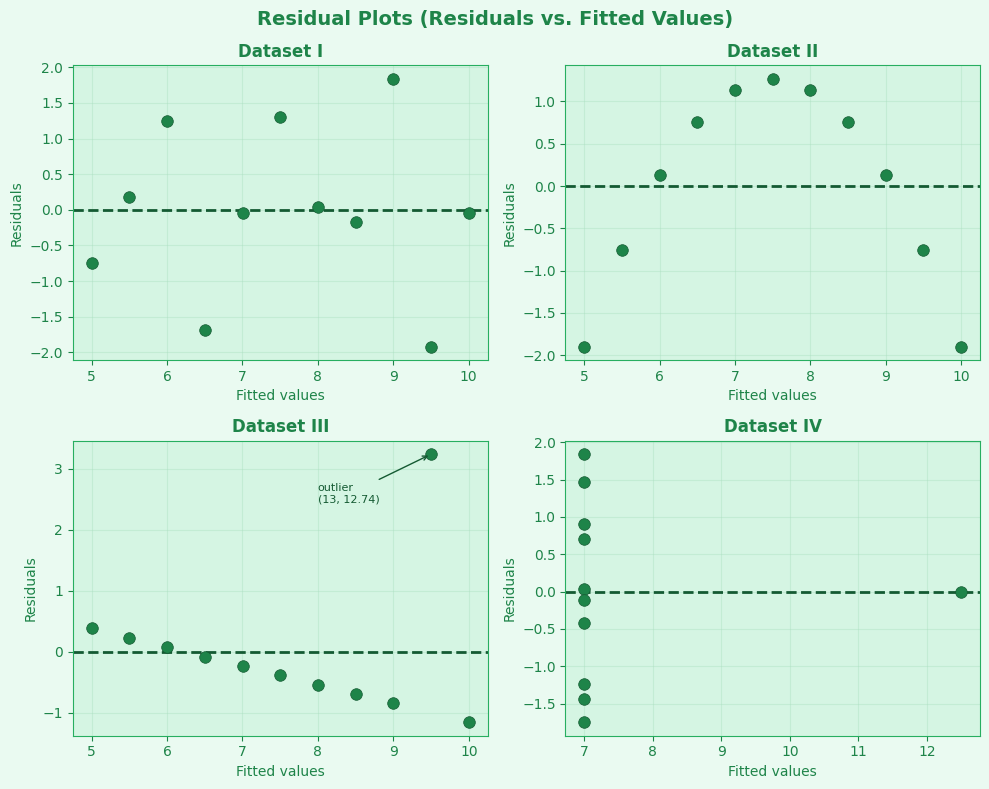

Saved: plot3_residuals.png


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.patch.set_facecolor('#EAFAF1')
fig.suptitle('Residual Plots (Residuals vs. Fitted Values)', fontsize=14, fontweight='bold', color='#1E8449')

for ax, ds in zip(axes.flat, datasets):
    g = df[df['dataset'] == ds]
    x, y = g['x'].values, g['y'].values
    b0, b1 = ols(g['x'], g['y'])
    fitted = b0 + b1 * x
    residuals = y - fitted

    ax.set_facecolor('#D5F5E3')
    ax.scatter(fitted, residuals, color='#1E8449', edgecolors='#145A32',
               linewidths=0.5, s=70, zorder=3)
    ax.axhline(0, color='#145A32', linewidth=2, linestyle='--')

    # Annotate the extreme residual in dataset III
    if ds == 'III':
        idx = np.argmax(np.abs(residuals))
        ax.annotate(f'outlier\n({x[idx]:.0f}, {y[idx]:.2f})',
                    xy=(fitted[idx], residuals[idx]),
                    xytext=(fitted[idx] - 1.5, residuals[idx] - 0.8),
                    fontsize=8, color='#145A32',
                    arrowprops=dict(arrowstyle='->', color='#145A32'))

    ax.set_title(f'Dataset {ds}', fontweight='bold', color='#1E8449')
    ax.set_xlabel('Fitted values', color='#1E8449')
    ax.set_ylabel('Residuals', color='#1E8449')
    ax.tick_params(colors='#1E8449')
    ax.grid(True, alpha=0.4, color='#A9DFBF')
    for spine in ax.spines.values():
        spine.set_edgecolor('#27AE60')

plt.tight_layout()
plt.savefig('plot3_residuals.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: plot3_residuals.png')

## Summary

| Dataset | Structure | Verdict |
|---------|-----------|--------|
| I | Linear with random noise | Linear model is appropriate |
| II | Curved (quadratic) | Need polynomial or non-linear model |
| III | Linear with one outlier | Outlier removal or robust regression needed |
| IV | Degenerate x with one leverage point | Linear model is meaningless here |

**Key lesson:** Always visualise your data. Summary statistics alone can be deeply misleading.